In [247]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

Seek ML algo to predict the direction of the next day’s return of MSFT adjusted closing price.

In [203]:
params = {
    'tickers':['MSFT','^VIX','SPY','XLK'],
    'start':'2022-01-03',
    'end':'2025-01-03', # ending later so we can get the target for '2024-12-31
    'auto_adjust':False,
    'progress':False
}

raw_data = yf.download(**params)

assert raw_data.isna().sum().sum() == 0, 'exists NA' # Throw error if missing data exists

In [204]:
tickers = params['tickers']
engineered_dict = {f'{ticker}_logreturns':[] for ticker in tickers}
for ticker in tickers:
    adj = raw_data.loc[:,('Adj Close',ticker)]
    log_returns = np.log(adj) - np.log(adj.shift(1))
    log_returns_vals = list(log_returns.values)
    engineered_dict[str(f'{ticker}_logreturns')].extend(log_returns)

    if ticker in ['MSFT']:
        ewma = log_returns.ewm(alpha=0.1, adjust=False).mean()
        engineered_dict[f'{ticker}_ewm'] = ewma

df = pd.DataFrame(engineered_dict, index=raw_data.index).dropna() # Drop NA

# Targets -> {1:'next day positive returns', -1:'next day negative returns'}
shifted = df['MSFT_logreturns'].shift(-1)
df['Target'] = shifted.apply(lambda x: 1 if pd.notna(x) and x > 0 else (-1 if pd.notna(x) else np.nan))
df = df.dropna()

In [214]:
# (X_tr, y_tr), (X_ts, y_ts)
split = {'prop_tr':0.90,'prop_ts':0.10}
assert abs(sum(split.values()) - 1.0) < 1e-8, "Split proportions must sum to 1.0"

n,p = df.shape
n_tr = int(n*split['prop_tr'])

X = df.drop(columns='Target')
y = df['Target']

X_tr, X_ts = X.iloc[:n_tr].values, X.iloc[n_tr:].values
y_tr, y_ts = y.iloc[:n_tr].values, y.iloc[n_tr:].values

scaler = StandardScaler() # Scale features
X_tr_scaled = scaler.fit_transform(X_tr)
X_ts_scaled = scaler.fit_transform(X_ts)

In [244]:
# Fit SVM w/o hyperparameter tuning
params = {
    'kernel':'rbf', 
    'gamma':1, 
    'C':1
}

n_splits=5 # Adjust as necessary

svm_model = SVC(**params)
cv = TimeSeriesSplit(n_splits=n_splits)
accuracy_dict = {f'split_{i}':[] for i in range(n_splits)}
for index, (tr_idx, val_idx) in enumerate(cv.split(X_tr_scaled)):
    fit = svm_model.fit(X_tr[tr_idx], y_tr[tr_idx])
    y_pred = fit.predict(X_tr[val_idx])
    accuracy = accuracy_score(y_pred=y_pred,y_true=y_tr[val_idx])
    accuracy_dict[f'split_{index}'] = accuracy

avg_accuracy = np.mean(list(accuracy_dict.values()))

print(f"""
The average accuracy across {n_splits} folds = {avg_accuracy*100:.2f}%
This slightly outperforms a random selection (50%) - hyperparameter tuning is required.
""")


The average accuracy across 5 folds = 50.71%
This slightly outperforms a random selection (50%) - hyperparameter tuning is required.



In [ ]:
# Hyperparameter Tuning


# Msc

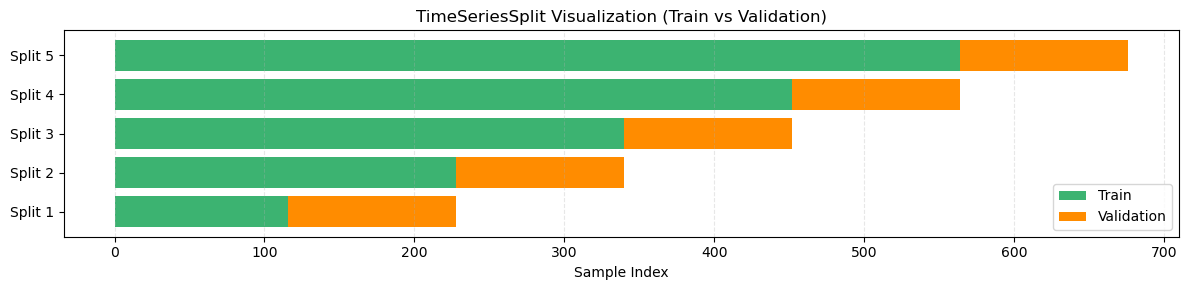

In [246]:
# Viz TimeSeriesSplit
fig, ax = plt.subplots(figsize=(12, 3))
for i, (train_idx, val_idx) in enumerate(cv.split(np.arange(len(X_tr)))):
    ax.broken_barh([(train_idx[0], len(train_idx))], (i - 0.4, 0.8), facecolors='mediumseagreen', label='Train' if i == 0 else "")
    ax.broken_barh([(val_idx[0], len(val_idx))], (i - 0.4, 0.8), facecolors='darkorange', label='Validation' if i == 0 else "")
ax.set_yticks(range(n_splits))
ax.set_yticklabels([f"Split {i+1}" for i in range(n_splits)])
ax.set_xlabel("Sample Index")
ax.set_title("TimeSeriesSplit Visualization (Train vs Validation)")
ax.legend(loc='lower right')
ax.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()